In [2]:
import pandas as pd
import numpy as np

region_names_df = pd.read_csv('/home/nader/source/Language-Navigation/habitat-matterport-3dresearch/statistics/HM3DSem-v0.2/Per_Scene_Region_Weighted_Votes.csv')

region_objects_df = pd.read_csv('/home/nader/source/Language-Navigation/habitat-matterport-3dresearch/statistics/HM3DSem-v0.2/Per_Scene_Region_Neighborhoods.csv')

In [8]:
region_objects_lists = region_objects_df['Object Instances in Region'].str.split(':')

irrelevant_objects = ['window','ceiling','floor','door','unknown','wall','window frame']

region_objects_lists = region_objects_lists.map(lambda x: [i.split('_')[0] for i in x if i.split('_')[0] not in irrelevant_objects])

region_objects = region_objects_lists.explode().unique()

region_objects_binary = [{value: row.count(value) for value in region_objects} for row in region_objects_lists]

region_objects_binary_df = pd.concat([pd.Series(row) for row in region_objects_binary], axis=1).T

region_objects_binary_df


,appliance,bed,cabinet,ceiling lamp,chair,door frame,drawer,fire alarm,heater,lamp,...,stack of jackets,bottles of water,desk door,file binder,bathroom stuff,decorative mask,slab,pedestal,model,molding
0,1,1,2,1,1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,2,1,0,1,2,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,3,1,0,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2594,0,0,0,0,3,2,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
2595,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,6
2596,0,0,0,0,4,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2597,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [9]:
# Filtering

region_names = region_names_df['Weighted Room Proposal'].str.strip()

filter = (region_names != 'Unknown room') & ~(region_names.str.startswith('Tie:'))

region_names_filtered = region_names[filter]

region_objects_df_filtered = region_objects_binary_df[filter]

region_names_unique = region_names_filtered.unique()

region_names_dict = {name: i for i, name in enumerate(region_names_unique)}

region_names_numerical = region_names_filtered.map(region_names_dict)

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

np.random.seed(42)

X = np.array(region_objects_df_filtered)
y = np.array(region_names_numerical)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


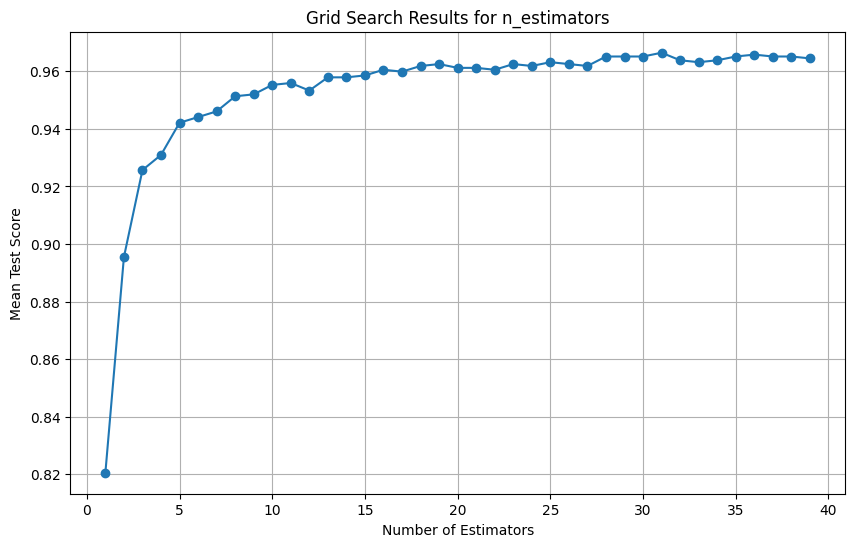

In [21]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


param_grid = {
    'n_estimators': np.arange(1, 40),
}

bst = XGBClassifier(learning_rate=1, max_depth=1, objective='binary:logistic')

grid_search = GridSearchCV(bst, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Convert results to DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(results['param_n_estimators'], results['mean_test_score'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Grid Search Results for n_estimators')
plt.grid(True)
plt.show()

In [31]:
bst2 = XGBClassifier(n_estimators = 35, max_depth=1, learning_rate=1, objective='binary:logistic')

bst2.fit(X_train, y_train)

pred = bst2.predict(X_test)

np.mean(pred == y_test)

0.984251968503937

In [32]:
filter_tie = region_names.str.startswith('Tie:')

region_names_tied = region_names[filter_tie].reset_index()['Weighted Room Proposal']

region_objects_df_tied = region_objects_binary_df[filter_tie]

region_objects_original_tied = region_objects_df[filter_tie].reset_index()

pred = bst2.predict(np.array(region_objects_df_tied))

pred_names = pd.Series([region_names_unique[i] for i in pred])

region_objects_original_tied['Tied Names'] = region_names_tied
region_objects_original_tied['Predicted Names'] = pred_names

In [33]:
region_objects_original_tied.to_csv('tied_disambiguation_numerical.csv')

In [43]:
filter_unknown = region_names == 'Unknown room'

region_names_unknown = region_names[filter_unknown].reset_index()['Weighted Room Proposal']

region_objects_df_unknown = region_objects_binary_df[filter_unknown]

region_objects_original_unknown = region_objects_df[filter_unknown].reset_index()

pred = bst2.predict(np.array(region_objects_df_unknown))

pred_names = pd.Series([region_names_unique[i] for i in pred])

region_objects_original_unknown['Unknown Names'] = region_names_unknown
region_objects_original_unknown['Predicted Names'] = pred_names

region_objects_original_unknown[pred_names != 'Bathroom'].to_csv('unknown_disambiguation_numerical.csv')